### Towards grapher 0.3

Formatting (recession bars, end point, end point label, etc)

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import timedelta

os.chdir('/home/brian/Documents/CPS/data/clean')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'axes.titlesize': 'x-large'})

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]

In [2]:
keep_cols = ['HRMONTH', 'EMP', 'PWSSWGT', 'AGE', 'STATE']
state1 = ['KY', 'TN']
state2 = ['OH', 'IN']
calcs = [('Kentucky and\nTennessee', '25 <= AGE <= 54 and STATE in @state1'),
         ('Ohio and\nIndiana', '25 <= AGE <= 54 and STATE in @state2')]

In [3]:
wm = lambda x: np.average(x, weights=df.loc[x.index, 'PWSSWGT']) * 100
mask = ' or '.join([f'({c[1]})' for c in calcs])
grouper = lambda x: pd.Categorical(
    np.where(x.eval(calcs[0][1]), calcs[0][0], calcs[1][0]))

In [4]:
data = pd.DataFrame()
for year in range(1994, 2019):
    df = (pd.read_feather(f'cps{year}.ft')
            .filter(keep_cols)
            .query(mask)
            .assign(GROUP = grouper))
    result = (df.groupby(['HRMONTH', 'GROUP'])
                .agg({'EMP': wm})).unstack()['EMP']
    result.index = pd.to_datetime([f'{year}-{i}-01' for i in result.index])
    data = data.append(result)

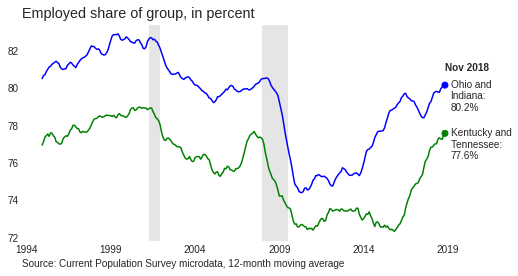

In [5]:
srs = data.rolling(12).mean()#.multiply(100.0)
title = 'Employed share of group, in percent'
plot = srs.plot(figsize=(8, 4), color=['green', 'blue'], legend=None)
for i, v in rec_dt:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.2)
ax = plt.scatter([srs.index[-1]] * 2, srs.iloc[-1].values, 
                 color=['green', 'blue'])
ax = plt.annotate(f'{srs.index[-1]:%b %Y}', (srs.index[-1], srs.iloc[-1].max() + 0.8), 
                  fontweight='bold')
ax = plt.title(title, loc='left')
for i, txt in enumerate(srs.iloc[-1].values):
    ax = plt.annotate(f'{srs.iloc[-1].index[i]}:\n{round(txt, 1)}%', 
                      (srs.index[-1] + timedelta(days=120), txt+0.3), va='top')
ax = plt.xlabel('Source: Current Population Survey microdata, 12-month moving average', ha='left', x=0)